# Comparison of `batchflow` performance with `tf` and `torch`

## Models

Firstly, we comapre `torch` and `tf` versions of `VGG16`. Train them on `MNIST`.

### TensorFlow model

In [ ]:
%%time

%run ./tf_model.py

... then restart kernel to clear GPU

### Torch model

In [1]:
%%time

%run ./torch_model.py

CPU times: user 10.3 s, sys: 6.84 s, total: 17.2 s
Wall time: 11.1 s


`torch` model is slightly faster.

## Research

Now let us compare `research` performances. We have the same experiment scheme and use four GPU units.

### TensorFlow model

In [1]:
import numpy as np
from multiprocessing import Process, Queue
import time
import matplotlib.pyplot as plt

import nvidia_smi

gpu_list = [2, 4, 5, 6]

def get_utilization(gpu_list):
    nvidia_smi.nvmlInit()
    handle = [nvidia_smi.nvmlDeviceGetHandleByIndex(i) for i in gpu_list]
    res = [nvidia_smi.nvmlDeviceGetUtilizationRates(item) for item in handle]
    return time.time(), [item.gpu for item in res]

def gpu_stat(gpu_list, forward, back):
    res = []
    while forward.empty():
        time.sleep(0.5)
        res.append(get_utilization(gpu_list))
    back.put(res)

def plot(res, gpu_list):
    times = np.array([item[0] for item in res])
    times = times - times[0]
    utilization = np.array([[item[1][j] for item in res] for j in range(len(gpu_list))])
    plt.figure(figsize=(15, 3))
    _ = [plt.plot(times, utilization[i]) for i in range(len(gpu_list))]
    plt.show()

In [2]:
forward = Queue()
back = Queue()

p = Process(target=gpu_stat, args=(gpu_list, forward, back))
p.start()

In [3]:
%%time

%run ./tf_research.py 4

Research tf_research_4 is starting...
CPU times: user 1min 24s, sys: 5.27 s, total: 1min 30s
Wall time: 4min 2s


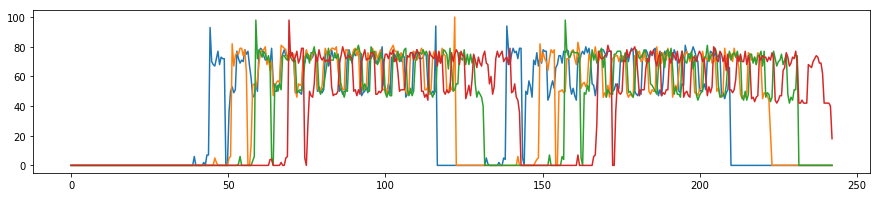

In [4]:
forward.put('stop')
tf_res = back.get()
plot(tf_res, gpu_list)

In [5]:
forward = Queue()
back = Queue()

p = Process(target=gpu_stat, args=([2], forward, back))
p.start()

In [6]:
%%time

%run ./tf_research.py 1

Research tf_research_1 is starting...
CPU times: user 1min 17s, sys: 2.61 s, total: 1min 20s
Wall time: 13min 47s


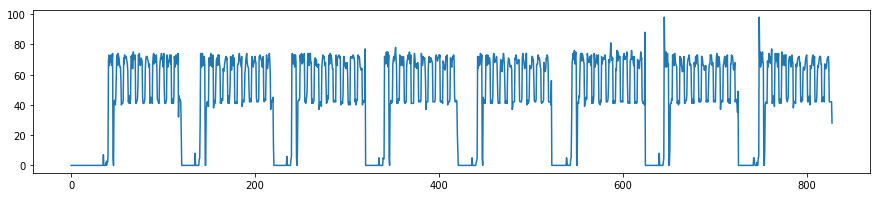

In [7]:
forward.put('stop')
tf_res = back.get()
plot(tf_res, [2])

### Torch model

In [8]:
forward = Queue()
back = Queue()

p = Process(target=gpu_stat, args=(gpu_list, forward, back))
p.start()

In [9]:
%%time

%run ./torch_research.py 4

Research torch_research_4 is starting...
CPU times: user 1min 22s, sys: 3.2 s, total: 1min 25s
Wall time: 3min 55s


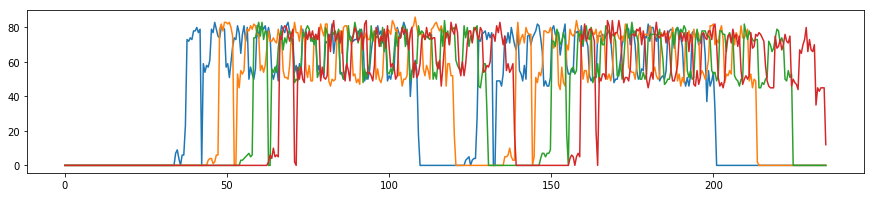

In [10]:
forward.put('stop')
torch_res = back.get()
plot(torch_res, gpu_list)

In [11]:
forward = Queue()
back = Queue()

p = Process(target=gpu_stat, args=([2], forward, back))
p.start()

In [12]:
%%time

%run ./torch_research.py 1

Research torch_research_1 is starting...
CPU times: user 1min 18s, sys: 3.28 s, total: 1min 21s
Wall time: 13min 8s


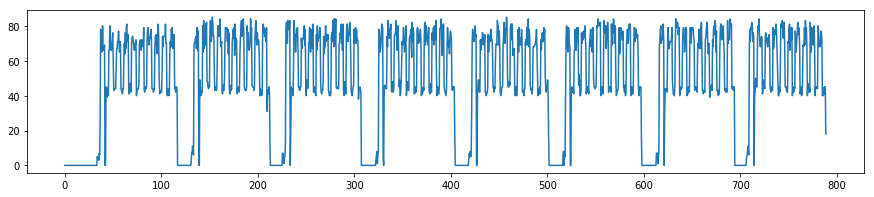

In [13]:
forward.put('stop')
torch_res = back.get()
plot(torch_res, [2])